This tutorial will show how to:

1. Explore datasets with one variable and two conditions
2. Implement nonparametric alternatives to the t-test
3. Explore datasets with two variables and one condition
4. Compute the Pearson correlation coefficients
5. Establish the error of the estimate, using bootstrap.
6. Test hypotheses on the correlation between two variables, using bootstrap.

In [7]:
%matplotlib inline


Welcome to pylab, a matplotlib-based Python environment [backend: module://IPython.zmq.pylab.backend_inline].
For more information, type 'help(pylab)'.


In [1]:
from __future__ import division
import numpy as np
import seaborn
seaborn.set()
colors = seaborn.color_palette()

### (1) Exploring a complex dataset: one variable, two conditions

Motivation: 

   Samples from a population will show variation in their means. So, when
   drawing two samples from a single population, there is some chance
   that the samples will have different means, even though the underlying
   population is the same.

Suppose two samples are drawn from the same distribution. There were always
be some non-zero likelihood of obtaining a difference in the means of these
samples, although no difference should actually be there.

The following simulation shows that given a population and finite
sample size there will always be some probability of getting a difference
between two random samples.
   
Furthermore, we will show that the probability of getting large spurious
differences increases as the sample size decreases.


In [6]:
# Generate a population with mean 0 and sd of 1
k = 10000
N = np.random.random(k)

# Next we will simulate three samples of differnet sizes from the distribution N
n = [8, 65, 512]

# There are a variety of ways of getting random samples, we'll do it here
# by permuting and taking the first k values in the resulting array.
# Note that this method will sample *without* replacement, in contrast to
# indexing with the return from randint(), as we did before.
d_empirical = list()
for k in n:
    sa = np.random.permutation(N)[:k]
    sb = np.random.permutation(N)[:k]
    d_empirical.append(sa.mean() - sb.mean())

print d_empirical

[0.040560488207148637, -0.013217333977442958, -0.0039837845532016969]


Because the two samples were drawn from the same distribution their
differences should be 0. But with samples of small size some spurious
difference can be observed.

Hereafter, we compute the probabilty of getting a spurious non-zero
difference between two samples. We test how the size of the sample
changes this probability. We will show that the smaller the sample size
the higher the probabilty of a spurios non-zero difference. 

Now we compute the distribution of differences between the means of two
random samples. We compute this distribution for each sample size and
plot the distributions one on top of eachother (with different color).

To plot the distribution, we're going to use a custom function called utils.pmf_hist. This will return values to plot a histogram that behaves like a probability mass function; i.e., this sum of the bar heights will equal 1. Note that this is different than using the ``normed=True`` argument to ``hist()``, which will plot a histogram where the bars *integrate* to 1 (they will be equivalent in cases where the bars have unit width).

For concise code, we're using a novel Python trick. the ``pmf_hist()`` function returns a three-tuple: x, h, w corresponding to the left x position of the bars, the height of the bars, and the width of the bars. These happen to be the three positional arguments to matplotlib's ``bar()`` function. We could do:

    x, h, w = pmf_hist(d)
    bar(x, h, w)

However, Python offers us a shortcut. Within the scope of a function call, you can prepend a variable name that points at some sequence with a single asterisk, and the result will be that the variable is passed as the positional arguments to the function. In other words, this is equivalent:

    args = pmf_hist(d)
    bar(*args)

Or, even less verbosely:

    bar(*pmf_hist(d))

Here this mostly saves us some typing, but it can be a useful usage pattern. You can see that we don't even need to know about the return values from ``pmf_hist()``, we just know that they correspond to the arguments to ``bar()``.

Finally, note that you can do something similar for keyword arguments, but here you pass a dictionary of key, value pairs and prepend it with a double astrisk:

    kwargs = dict(color="blue", size=10)
    bar(*args, **kwargs)


In [13]:
n_samples = 100
for i, k in enumerate(n):
    sa = np.zeros(k)
    sb = np.zeros(k)
    
    sa, sb = [], []
    for j in xrange(n_samples):
        sa.append(np.random.permutation(N)[:k])
        sb.append(np.random.permutation(N)[:k])
    
    # Compute the difference vector and plot a histogram
    # Represent the histogram as a PMF
    
    d = np.mean(sa, axis=1) - np.mean(sb, axis=1)
    np.bar(*utils.pmf_hist(d, 20), color=colors[i], alpha=0.5, label="sample size = %d" % k)

# Add some description to the plot
title("Probability of getting a spurious\ndifference between two random samples\nas function of sample size.")
ylabel("Probability of occurrence")
xlabel("Difference between random samples")

# Additionally, plot the empirical diffences we obtained in the first step as vertical lines
colors = seaborn.color_palette("deep")
for i, d in enumerate(d_empirical):
    axvline(d, color=colors[i], linewidth=2)
    
legend(loc="best");

AttributeError: 'module' object has no attribute 'bar'

Notice that the blue distribution, the one generated by reampling with
the smallest sample size (8) has the largest standard deviation. This
means that with such small sample size there is a higher chance of
observing a spurious difference. For example the probability of
occurrence of a difference of nearly +/-0.5 should be around 0.1 (10%,
blue bar). The probability goes down to less then 0.01 with a larger
sample size. 

If a scientific article were to report a *statistically* significant difference of 0.5 on this scale.

How would you be able to tell whether their analyses and statistical tests were performed correctly?

How could we relate this to a power analysis?

### (2) Nonparametric altenatives to a t-test

A t-test is a statistical method to establish the likelihood of the
difference between the means of two samples drawn from an unknown
distribution. The shape of this distribution is assumed to be gaussian.

The null-hypothesis for this test is: The two sample come from the same
distribution. 

A t-test finds the probability that the two means were drawn from the
same distribution. If that probability is small we can reject the null
hypothesis and support the alternative hypothesis that the two samples
did not come from the same distribution. 

Here after we show how to use bootstrap to generate the equivalent of a
t-test.

We first generate the distribution for a population that is not gaussian.

Generate the population using mixture of a Chi-Square distribution with 6
degrees of freedom and a standard normal.

Because this population is not Gaussian, a parametric t-test would not be
appropriate.

In [11]:
k = 10000
N = concatenate([chisquare(6, k / 2), randn(k / 2)])
mu = mean(N)
me = median(N)
sd = std(N)

Let's take a look at the population we just generated

We make a histogram of population and appreciate how well mean, median and
standard deviation might describe the distribution.

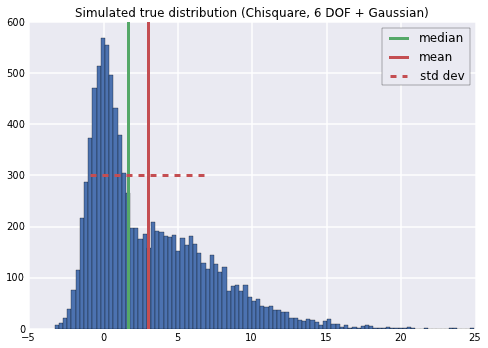

In [12]:
hist(N, 100)
axvline(me, label="median", color=colors[1], linewidth=3)
axvline(mu, label="mean", color=colors[2], linewidth=3)
sd_y = ylim()[1] * .5
plot([mu - sd, mu + sd], [sd_y] * 2, "--", color=colors[2], linewidth=3, label="std dev")
title("Simulated true distribution (Chisquare, 6 DOF + Gaussian)")
legend();

Now let's set up a bootstrap test of the difference between the means of
two samples that does not rely on the assumption that the popluation is
gaussian. As our population is not.

We simulate two empirical samples of size n and m drawn from our
distribution.  As if we were to run two conditions of the same
experiment.

By drawing the two sampels from the same distribution we are effectively
making the null hypothesis true.

In [13]:
n = 4
m = 8
sa = permutation(N)[:n]
sb = permutation(N)[:m]

d_empirical = mean(sa) - mean(sb)

The first test we show is called a Randomization test (Test of the
difference of means of two samples).

So, we want to test the null hypothesis (H0) that the means of the two
samples come from the same distribution.

To do so we will first aggregate the two samples. Under the null
hypothesis the two samples are interchanganble because they come from the
same distribution.

In [14]:
sh0 = concatenate((sa, sb))

Then resample 10,000 times, effectively building 10,000 new samples from the aggregated sample

In [15]:
k = 10000
sa_rand = zeros((n, k))
sb_rand = zeros((m, k))
for i in xrange(k):
    iter_dist = permutation(sh0)
    sa_rand[:, i] = iter_dist[:n]
    sb_rand[:, i] = iter_dist[n:]

Now compute the differences between the means of these resampled samples and plot.

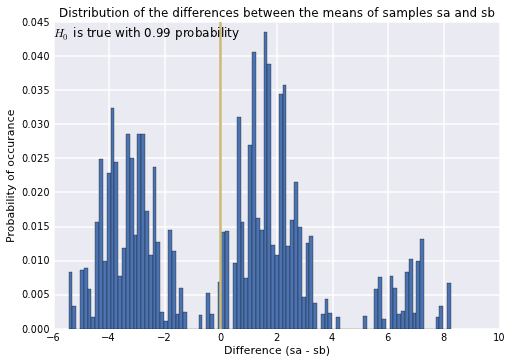

In [16]:
d = sa_rand.mean(axis=0) - sb_rand.mean(axis=0)
bar(*utils.pmf_hist(d, 100))
title("Distribution of the differences between the means of samples sa and sb")
ylabel("Probability of occurance")
xlabel("Difference (sa - sb)")

# Plot the actual difference we got
plot([d_empirical, d_empirical], ylim(), color=colors[4], linewidth=2.5)

# Get the probability of such a result by counting the number of larger (absolute) differences
p = sum(abs(d) > abs(d_empirical)) / k
text(xlim()[0], ylim()[1] * .95, "$H_0$ is true with %.2f probability" % p, size=12);

The second test we show is called a Bootstrap test (Test of the
difference of mean of two samples).

This example is identical to the previous one, with one importnt
difference. During the bootstrap proces samples are generated 'with
replacement.'

This means that on each new draw there will be equal likelihood to sample
any element of the aggregated sample. 

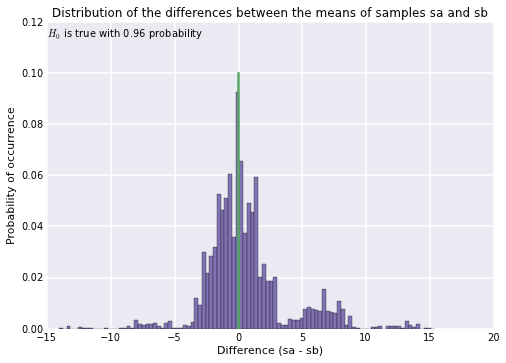

In [17]:
# First aggregate the samples
sh0 = concatenate((sa, sb))

# Resample 10,000 times with replacement
k = 10000
sa_rand = zeros((n, k))
sb_rand = zeros((m, k))
for i in xrange(k):
    sa_rand[:, i] = sh0[randint(0, n + m, n)]
    sb_rand[:, i] = sh0[randint(0, n + m, m)]
    
# Compute the difference and plot as before
d = median(sa_rand, axis=0) - median(sb_rand, axis=0)

bar(*utils.pmf_hist(d, 100), color=colors[3])
title('Distribution of the differences between the means of samples sa and sb')
ylabel('Probability of occurrence')
xlabel('Difference (sa - sb)')

plot([d_empirical] * 2, ylim(), color=colors[1], linewidth=2.5)

p = sum(abs(d) > abs(d_empirical)) / k
text(xlim()[0], ylim()[1] * .95, "$H_0$ is true with %.2f probability" % p);

**A note on Python string formatting:**

Python's string formatting uses identical format codes as in C, but is built into the string object itself. Thus, using the ``%`` operator between a string with format codes and a tuple (or single object) with values to plug into those codes will create a formatted string.

In case you were wondering (as you may have been in the original MATLAB tutorial, it's easy to do a parametric t-test in Python, if you are so inclined:

In [18]:
from scipy.stats import ttest_ind
t, p = ttest_ind(sa, sb)
print "t = %.2f; p = %.3f" % (t, p)

t = -0.02; p = 0.988


### (3) Exploring a more complex dataset: two variables, one condition

Hereafter, we show an example of a slightly more complex data set.

So suppose we have one condition and measure not just one quantity (which
was the subject of Lecture 1) but measure two distinct quantities. For
example, suppose we measure both the heights and weights of male adults.

What can we do with the data? 

Let's generate two samples rapresenting two variables drawn from gaussian
distributions. The two variables are correlated with eachother.

In [19]:
n = 100
w = 0.6
s1 = randn(n)
s2 = w * s1 + (1 - w) * randn(n)

### (4) Correlation

We can quantify how correlated two variables are by using the metric
'correlation.'

Correlation values lie in the range -1 to 1, where -1 indicates a perfect
negative linear relationship, 0 indicates no relationship, and 1
indicates a perfect positive linear relationship. (Note that we
will use Pearson's product-moment correlation, but there are other variants of
correlation.)

Pearson's r is defined as

$$r = \frac{1}{n}\sum ^n _{i=1}\left[\left(\frac{X_i - \bar{X}}{s_X}\right)\left(\frac{Y_i - \bar{Y}}{s_Y}\right)\right]$$

In other words, we z-score each variable and then compute the average product of the variables.

In Python, we can compute this in a variety of ways:

In [20]:
# First there's the longwinded arithmetic
# (Note this isn't all that longwinded since it's a vectorized calculationg)
r1 = mean(((s1 - s1.mean()) / s1.std()) * ((s2 - s2.mean()) / s2.std()))

# We can also use functions from the scipy.stats package
from scipy import stats
r2 = mean(stats.zscore(s1) * stats.zscore(s2))

# This package even offers a one-step function
# Note this returns a tuple (r, p)
r3, p3 = stats.pearsonr(s1, s2)

print "%.3f, %.3f, %.3f" % (r1, r2, r3)

0.823, 0.823, 0.823


We can also visualize the relationship with a scatterplot

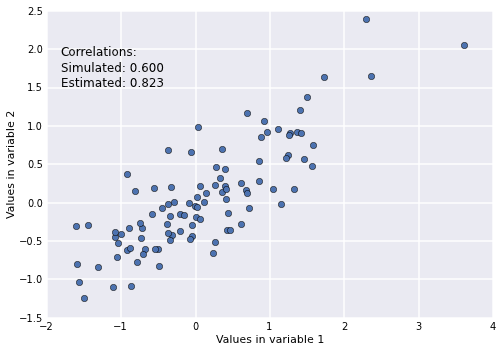

In [29]:
# Note that scatter(s1, s2) is equivalent to plot(s1, s2, "o")
plot(s1, s2, "o")
xlabel("Values in variable 1")
ylabel("Values in variable 2")

# We can display the simulated and computed correlations
annot = "Correlations:\nSimulated: %.3f\nEstimated: %.3f" % (w, r1)
text(xlim()[0] + .2, ylim()[1] - 1, annot, size=12);

### (5) Error bars

- How do we obtain error bars on the correlation observed in a set of data?

- How do we test whether the correlation observed in a set of data is
  significantly different from zero? 

Hereafter, we compute errorbars on the correlation coefficient using
bootstrap.

We compute k bootstrap (resampling with replacement) with the same size
of the original samples. 

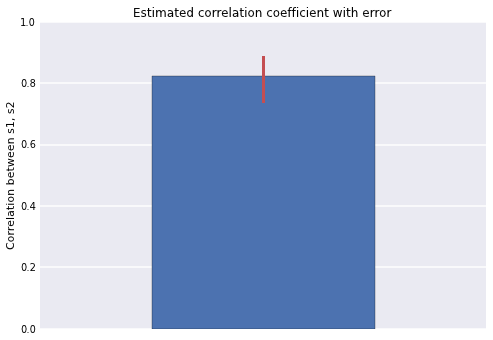

In [22]:
# Number of samples
k = 1000
r_dist = zeros(k)

# Do the bootstrap
for i in xrange(k):
    idx = randint(0, n, n)
    r_dist[i] = stats.pearsonr(s1[idx], s2[idx])[0]

# Compute the two-tailed 95% confidence intervals
ci = utils.percentiles(r_dist, [2.5, 97.5])

# Plot the correlation with error bars
bar(0.5, r1, width=1)
plot([1, 1], ci, color=colors[2], linewidth=3)
xlim(0, 2)
ylim(0, 1)
xticks(())
title("Estimated correlation coefficient with error")
ylabel("Correlation between s1, s2");

### (6) Test hypotheses

Now we want to test the hypothesis that the correlation r, was not
obtained by chance. We want to find the probability for the null
hypothesis to be true.

If the null hypothesis were true, we would be able to shuffle the
order of each variable and obtain datasets that are equivalent to the
original dataset. So, to obtain a p-value, we shuffle each variable,
calculate a correlation value for each shuffled sample. We repeat this
process a large number of times and count the number of times that
randomly obtained correlation values are more extreme than the actual
observed correlation value.

We create a bootstrap distribution of samples under the null hypothess
that s1 and s2 were not correlated.

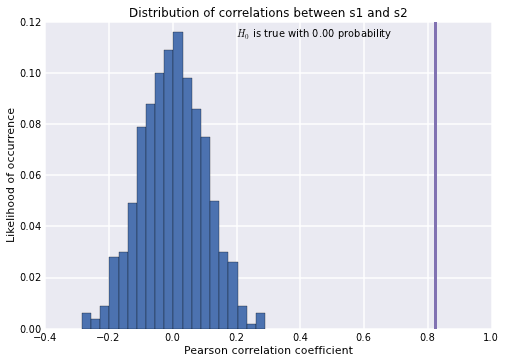

In [23]:
k = 1000
r_dist = zeros(k)
for i in xrange(k):
    s1_rand = s1[randint(0, n, n)]
    s2_rand = s2[randint(0, n, n)]
    r_dist[i] = stats.pearsonr(s1_rand, s2_rand)[0]

bar(*utils.pmf_hist(r_dist, 20))
title('Distribution of correlations between s1 and s2')
ylabel('Likelihood of occurrence')
xlabel('Pearson correlation coefficient')

# Now plot the empirical correlation value
axvline(r1, color=colors[3], linewidth=3)
p = sum(abs(r1) < abs(r_dist)) / k
text(0.2, ylim()[1] * .95, "$H_0$ is true with %.2f probability" % p);